## Notebook for meta analysis of experiments (e.g. determining exclusion criteria)

In [1]:
%run ./rob_setup_notebook.ipynb

from ia_funcs import *
import utils.STAMovieMaker_noGUI as STAMM
import utils.gsheets_importer as gsi


Suite2p path: ['/home/rlees/Documents/Code/suite2p/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Plots 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


### Define list of pickled objects to meta analyse

In [2]:
pkl_list = [
#             '2019-06-11_J048.pkl',
#             '2019-06-13_J052.pkl',
#             '2019-06-25_RL048.pkl',
#             '2019-07-15_RL052.pkl',
#             '2019-08-14_J058.pkl',
#             '2019-08-14_J059.pkl',
#             '2019-08-15_RL055.pkl',
            '2019-11-14_J061.pkl',
            '2019-11-14_J063.pkl',
            '2019-11-15_J064.pkl',
            '2019-11-18_J065.pkl',
            '2020-02-27_RL075.pkl',
            '2020-03-03_RL074.pkl',
            '2020-03-05_RL070.pkl',
            '2020-03-05_RL072.pkl',
#             '2020-03-12_RL070.pkl',
#             '2020-03-16_RL074.pkl',
#             '2020-03-19_RL075.pkl',
#             '2020-03-20_RL080.pkl'
           ]

for i,pkl in enumerate(pkl_list):
    pkl_list[i] = os.path.join(qnap_path, 'pkl_files', pkl)

print(pkl_list)

['/home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl', '/home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl', '/home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl', '/home/rlees/mnt/qnap/pkl_files/2019-11-18_J065.pkl', '/home/rlees/mnt/qnap/pkl_files/2020-02-27_RL075.pkl', '/home/rlees/mnt/qnap/pkl_files/2020-03-03_RL074.pkl', '/home/rlees/mnt/qnap/pkl_files/2020-03-05_RL070.pkl', '/home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl']


### Make STA movies and images

In [5]:
for pkl in pkl_list:
    
    with open(pkl, 'rb') as f:
        ses_obj = pickle.load(f)

    exp_list = [ses_obj.photostim_r, ses_obj.photostim_s]

    if ses_obj.spont.n_frames > 0:
        exp_list.append(ses_obj.spont)

    if ses_obj.whisker_stim.n_frames > 0:
        exp_list.append(ses_obj.whisker_stim)

    for exp_obj in exp_list:

        for file in os.listdir(exp_obj.tiff_path):
            if '.tif' in file:
                movie_path = os.path.join(exp_obj.tiff_path, file)
                break
        
        if exp_obj.stim_type == 'none':
            sync_path = ses_obj.photostim_r.paq_path
            stim_channel = ses_obj.photostim_r.stim_channel
        else:
            sync_path = exp_obj.paq_path
            stim_channel = exp_obj.stim_channel

        print('Movie_path:', movie_path,
              '\nSync_path:', sync_path)

        arg_dict = {'moviePath' : movie_path, # hard-code this
                    'savePath' : stam_save_path,
                    'syncFrameChannel' : 'frame_clock',
                    'syncStimChannel' : stim_channel,
                    'syncStartSec' : 0,
                    'syncStopSec' : 0,
                    'numDiffStims' : 1,
                    'startOnStim' : 1,
                    'everyXStims' : 1,
                    'preSeconds' : 1,
                    'postSeconds' : 3,
                    'frameRate' : 15,
                    'averageImageStart' : 0.5,
                    'averageImageStop' : 1.5,
                    'methodDF' : False,
                    'methodDFF' : True,
                    'methodZscore' : False,
                    'syncPath' : sync_path,
                    'zPlanes' : exp_obj.n_planes,
                    'useStimOrder' : False,
                    'stimOrder' : [],
                    'useSingleTrials' : False,
                    'doThreshold' : False,
                    'threshold' : 0,
                    'colourByTime' : False,
                    'useCorrelationImage' : False,
                    'blurHandS' : False,
                    'makeMaxImage' : True,
                    'makeColourImage' : False
                   }

        STAMM.STAMovieMaker(arg_dict);
            
# staMovie(stam_save_path, pkl_list) # old function that used lots of RAM

Movie_path: /home/rlees/mnt/qnap/Data/2019-06-13/J052/2019-06-13_J052_t-004/2019-06-13_J052_t-004_Ch3.tif 
Sync_path: /home/rlees/mnt/qnap/Data/2019-06-13/J052/2019-06-13_J052_t-004.paq
Loading sync file
Loading movie
Plane 1 of 2. Stim 1 of 1 (100 trials)
Plane 1 of 2. Stim 1 of 1 (100 trials) - Raw
Plane 1 of 2. Stim 1 of 1 (100 trials) - dFF
Plane 2 of 2. Stim 1 of 1 (100 trials)
Plane 2 of 2. Stim 1 of 1 (100 trials) - Raw
Plane 2 of 2. Stim 1 of 1 (100 trials) - dFF
Movie_path: /home/rlees/mnt/qnap/Data/2019-06-13/J052/2019-06-13_J052_t-005/2019-06-13_J052_t-005_Ch3.tif 
Sync_path: /home/rlees/mnt/qnap/Data/2019-06-13/J052/2019-06-13_J052_t-005.paq
Loading sync file
Loading movie
Plane 1 of 2. Stim 1 of 1 (100 trials)
Plane 1 of 2. Stim 1 of 1 (100 trials) - Raw
Plane 1 of 2. Stim 1 of 1 (100 trials) - dFF
Plane 2 of 2. Stim 1 of 1 (100 trials)
Plane 2 of 2. Stim 1 of 1 (100 trials) - Raw
Plane 2 of 2. Stim 1 of 1 (100 trials) - dFF


### Retrieve suite2p masks

In [4]:
# Save a stack of masks from suite2p along with mean image and STA images
# in the order: mean image, all rois, cells, s2, pr targets, ps targets, 
# whisker responsive, pr STA image, ps STA image

parent_folder = os.path.join(qnap_path, 'Analysis', 'Suite2p_masks')
s2pMaskStack(pkl_list, stam_save_path, parent_folder)

### Plot average cellular fluorescence across session

Measuring mean cell fluorescence for: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl               
Plotting mean cell fluorescence...


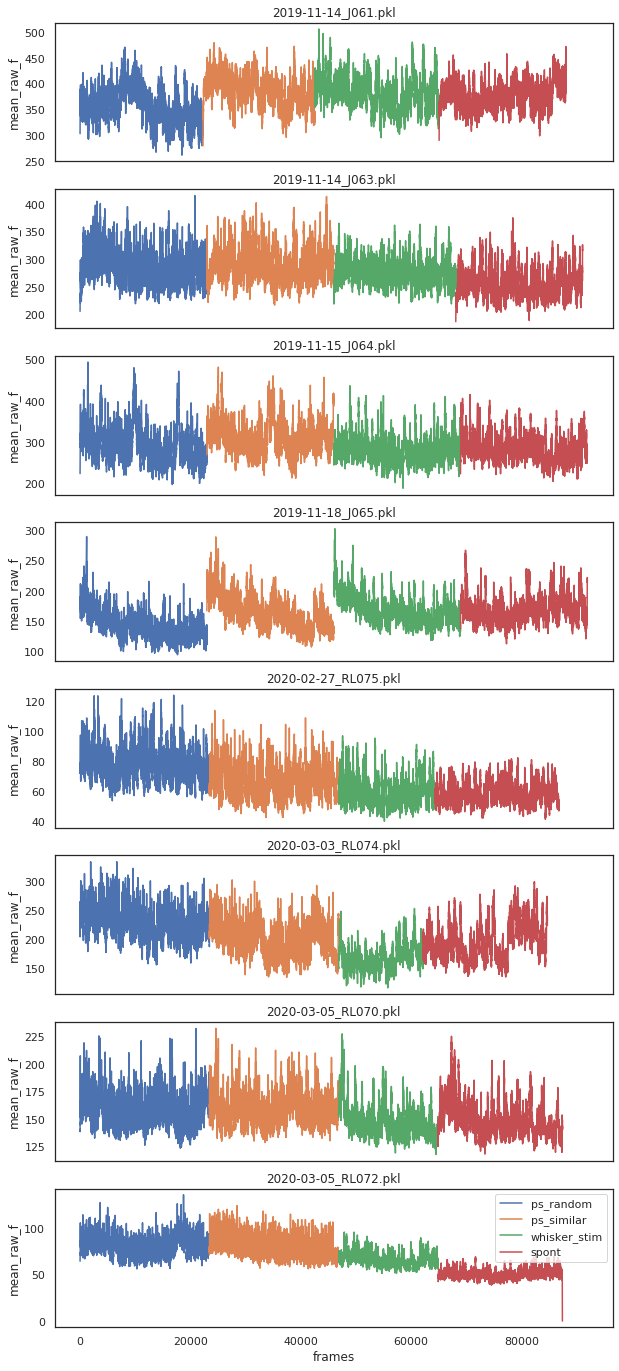

In [5]:
cellFluTime(pkl_list)
# plt.savefig(os.path.join(fig_save_path, 'cell_fluorescence_time.svg'));

### Make downsampled stack of first 1000 and last 1000 frames of each experiment for all sessions

In [ ]:
save_path = os.path.join(qnap_path, 'Analysis', 'Drift_check', 'Raw')
downsampleTiff(pkl_list, save_path)

### Plot frame fluorescence over time for each experiment in all sessions

In [ ]:
data_folder = os.path.join(qnap_path, 'Analysis', 'Drift_check', 'Stacks')
frameFluTime(pkl_list, data_folder, legend=False)
plt.savefig(os.path.join(fig_save_path, 'frame_fluorescence_time.svg'));

### Combine two iscell.npy Suite2p output files

In [3]:
for pkl in pkl_list:
        
    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)

    s2p_path = ses_obj.s2p_path
    extra_iscell_path = os.path.join(qnap_path, 'iscell_manual_backup', ses_obj.sheet_name + '_iscell.npy')

    # s2p_path is used to find current iscell file and extra iscell file is added to it
    # backup iscell file is made first before saving new iscell.npy file
    combineIscell(s2p_path, extra_iscell_path)
    
    print('Combined iscell.npy files for', pkl, '...       ', end='\r')